In [1]:
import os
import sys
import cv2
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Input
from keras.applications.vgg16 import VGG16
from force_utils import database, show_history

Using TensorFlow backend.


In [2]:
dataset = database('dataset/movie.mp4', 'dataset/forceinfo.csv')

In [3]:
input_shape = (299, 299, 3)
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=input_shape))
x = base_model.output
x = Flatten(input_shape=base_model.output_shape[1:])(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(1)(x)

model = Model(inputs=base_model.input, outputs=prediction)
model.load_weights('dataset/weights/weights_02.h5')

In [4]:
frames, preds, errors = dataset.evaluate_model(input_shape, model, 62000)

69820 / 69821

In [8]:
errors = np.array(dataset.errors)

In [10]:
np.sum(errors)

1776.4088261761665

## Show Histogram

In [14]:
# convolve
average = 59
conv_preds = np.convolve(preds, np.ones(average)/float(average), 'same')
conv_answer_vals = np.convolve(dataset.answer_vals, np.ones(average)/float(average), 'same')
conv_errors = np.convolve(errors, np.ones(average)/float(average), 'same')

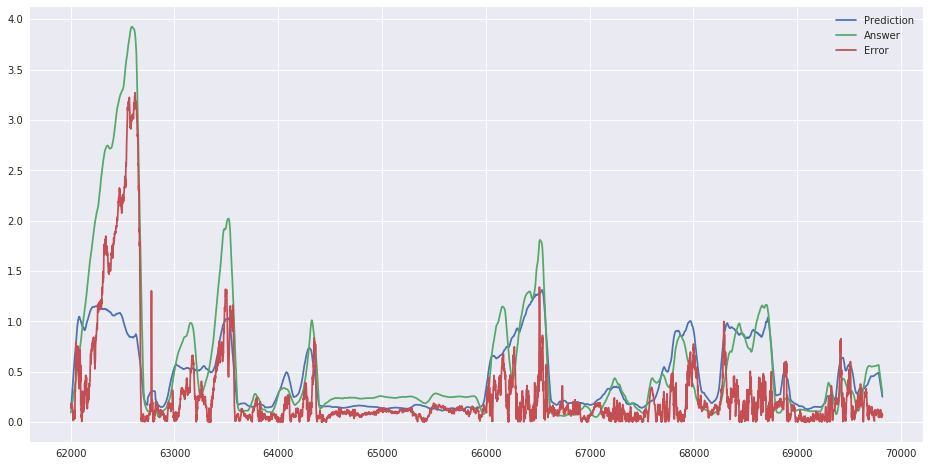

In [15]:
import seaborn as sns
bins = 80
norm_hist = True

sns.set()
plt.figure(figsize=(16, 8))
plt.plot(frames, conv_preds, label='Prediction')
plt.plot(dataset.answer_keys, conv_answer_vals, label='Answer')
plt.plot(frames, errors, label='Error')
#plt.plot([65000, 65000], [4, 2], 'k-', lw=2)
# https://blog.amedama.jp/entry/2018/07/13/001155
#sns.distplot(preds, kde=False, bins=bins, norm_hist=norm_hist, label='Prediction')
#sns.distplot(answer_vals, kde=False, bins=bins, norm_hist=norm_hist, label='Answer')
#plt.xlabel('Confidence')
#plt.ylabel('Density')
plt.legend()

## Show Movie

In [5]:
video_file = './dataset/movie.mp4'
cap = cv2.VideoCapture(video_file)
# you should set start_frame to appropriate value(i.e start_frame)
#cap.set(1, 18990) # within training
#cap.set(1, 55865) # start of validation
cap.set(1, 63000)
font = cv2.FONT_HERSHEY_SIMPLEX
font_size = 15

while(cap.isOpened()):
    ret, frame = cap.read()
    frame_num = cap.get(1)
    img = Image.fromarray(np.uint8(frame[:,:,:])).resize((input_shape[0], input_shape[1]))
    img = np.asarray(img)
    img = img[np.newaxis, :, :, :]
    pred = model.predict(img / 255.0)[0][0]
    max_force = np.max(force)
    force_meter = pred / max_force
    
    if pred > 3:
        color = (0,0,255)
    elif pred > 1.5:
        color = (0,255,0)
    else:
        color = (255,0,0)
        
    dst = cv2.rectangle(frame,
                        (int(frame.shape[1]*0.85), int(frame.shape[0]*(-0.6*force_meter+0.8))),
                        (int(frame.shape[1]*0.9), int(frame.shape[0]*0.8)),
                        color, -1)
    
    dst = cv2.putText(dst, str(np.round(pred, 3)),
                      (int(frame.shape[1]*0.85), int(frame.shape[0]*(-0.6*force_meter+0.78))),
                      font, 1, color, 2, cv2.LINE_AA)
    
    dst = cv2.putText(dst, str(int(frame_num)),
                      (int(frame.shape[1]*0.85), int(frame.shape[0]*0.85)),
                      font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('frame', dst)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

## Show History

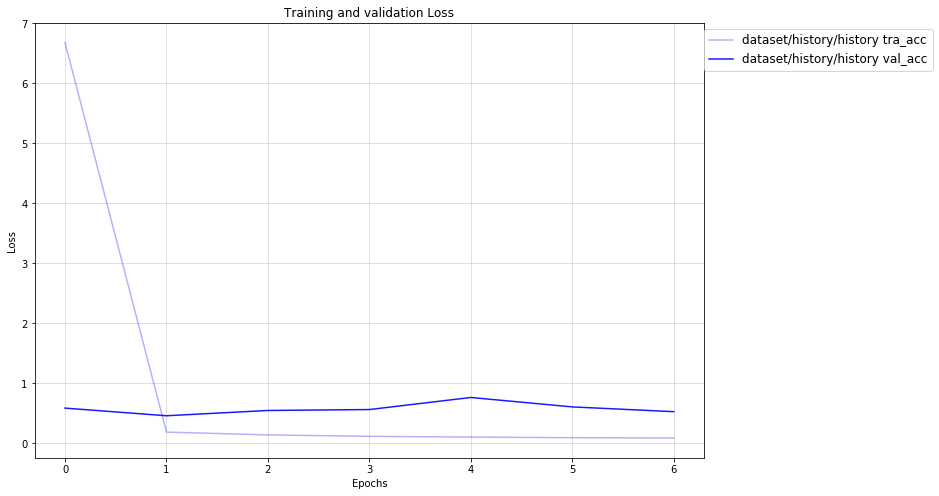

In [3]:
show_history(False, 'dataset/history/history.txt')